In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from keras.layers import Dense, Activation, Input, LSTM, Permute, Reshape, Masking, TimeDistributed, MaxPooling1D, Flatten, Bidirectional
from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU
from keras.layers.normalization import BatchNormalization

# Install TensorFlow

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from tqdm import tqdm
from matplotlib.colors import LogNorm

TensorFlow 2.x selected.


Using TensorFlow backend.


In [2]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1-kLULQZBXB90J_k1cPRDNO-j-NWD6osp' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


title: events_im.npy, id: 1fM5GAZwk04w_bBXa9qAxq23ufAZX7tuF
downloading to /root/data/events_im.npy


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

noise_dim = 100
num_examples_to_generate = 16

BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(15*15*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((15, 15, 128)))
    assert model.output_shape == (None, 15, 15, 128) # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 30, 30, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 60, 60, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    
    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 120, 120, 1)


    return model

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[120, 120, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    #return tf.keras.losses.MSE(tf.ones_like(fake_output), fake_output)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, BATCH_SIZE, noise_dim, noise):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [0]:
def train(dataset, epochs, ret_loss = False):
  gen_loss = []
  disc_loss = []
  for epoch in tqdm(range(epochs)):
    start = time.time()
    
    for image_batch in dataset:
      gl, dl = train_step(image_batch, BATCH_SIZE, noise_dim, noise)
    
    #appending last loss from batch training
    gen_loss.append(gl)
    disc_loss.append(dl)
  
  if ret_loss:
    return gen_loss, disc_loss
    

In [0]:
def save(generator, discriminator):
    discriminator.trainable = False
    discriminator.trainable = True
    save_model(generator, 'generator')
    save_model(discriminator, 'discriminator')

tf.Tensor(
[[[[ 9.25500994e-04]
   [ 6.02065120e-04]
   [-1.85439433e-03]
   ...
   [-2.07115285e-04]
   [-5.50685741e-04]
   [-1.35828195e-05]]

  [[ 1.21163402e-03]
   [-4.84311691e-04]
   [ 5.03878109e-05]
   ...
   [-8.78429273e-04]
   [-9.88655258e-04]
   [-8.14620696e-04]]

  [[-8.70266347e-04]
   [ 1.89707463e-03]
   [-1.80876232e-04]
   ...
   [ 3.44152679e-04]
   [-2.94773374e-04]
   [-2.02098070e-03]]

  ...

  [[-3.07574542e-03]
   [-1.46663981e-03]
   [-4.61725518e-03]
   ...
   [-4.74287197e-03]
   [ 3.66276875e-03]
   [-1.45104225e-03]]

  [[ 5.17302705e-03]
   [-1.22504390e-03]
   [-2.57324474e-03]
   ...
   [-7.00633507e-03]
   [-7.60277361e-03]
   [-2.91602989e-03]]

  [[-2.47457283e-05]
   [ 7.83955562e-04]
   [-4.46218438e-03]
   ...
   [-3.05709336e-03]
   [-1.95673364e-03]
   [-3.19141266e-03]]]], shape=(1, 120, 120, 1), dtype=float32)


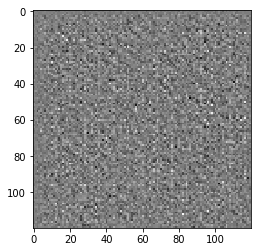

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

print(generated_image)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-4.195846e-05]], shape=(1, 1), dtype=float32)


In [20]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

seed = tf.random.normal([num_examples_to_generate, noise_dim])

train_images = np.load("/root/data/events_im.npy")[:50]

#normalizing images
train_images_norm = []
scaler = MinMaxScaler((-1,1))

for im in train_images:
  scaler.fit(im)
  im = scaler.transform(im)
  train_images_norm.append(im)
 
train_images = np.array(train_images_norm)
print(train_images.shape)

(50, 120, 120)


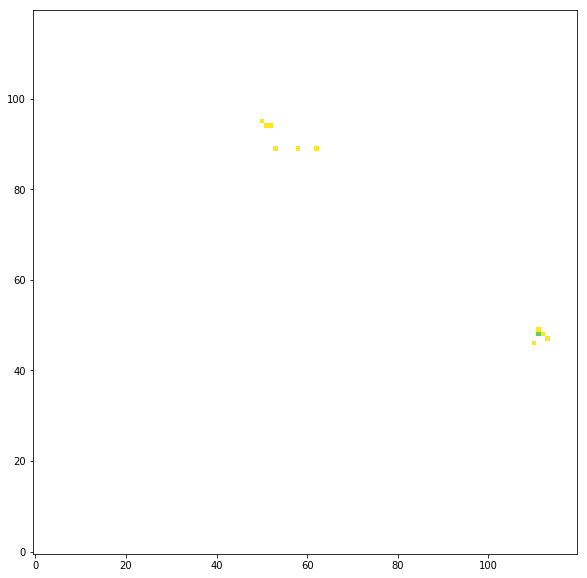

In [21]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(10,10))
plt.imshow(train_images[10],origin='lower',norm=LogNorm(vmin=0.01))

In [0]:
train_images = train_images.reshape(train_images.shape[0], 120, 120, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

g_loss, d_loss = train(train_dataset, 5000, ret_loss = True)

 97%|█████████▋| 4863/5000 [16:58<00:35,  3.82it/s]

In [0]:
nnoise = tf.random.normal([1, 100])
generated_image = generator(noise, training=True)

fig = plt.figure(figsize=(15,15))
plt.imshow(generated_image[0, :, :, 0], origin='lower',norm=LogNorm(vmin=0.01))
fig.show()

print(nnoise)

In [0]:
plt.plot(g_loss)
plt.title("generator loss")
plt.xlabel("batch size = 10 step x 2000 epochs")
plt.ylabel("crossentropy")

In [0]:
plt.plot(d_loss)
plt.title("discriminator loss")
plt.xlabel("batch size = 10 step x 2000 epochs")
plt.ylabel("crossentropy")